### Order of faces using ISOMAP
Georgia Tech - OMSA  
ISYE-6740 - HW2 - Q3

This problem aims to reproduce the ISOMAP algorithm results in the original paper for ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323. The file isomap.mat (or isomap.dat) contains 698 images, corresponding to different poses of the same face. Each image is given as a 64 × 64 luminosity map, hence represented as a vector in $\mathbb{R}^{4096}$. This vector is stored as a row in the file. (This is one of the datasets used in the original paper.) In this instance, we are implementing the ISOMAP algorithm from scratch. We will find the shortest path (required by one step of the algorithm), using https://scikit-learn.org/stable/modules/generated/sklearn.utils.raph_shortest_path.graph_shortest_path.html.  
Using Euclidean distance (i.e., in this case, a distance in R4096) to construct the ϵ-ISOMAP. We will tune the ϵ parameter to achieve the most reasonable performance. Please note that this is different from K-ISOMAP, where each node has exactly K nearest neighbors.  

We start by importing the modules and creating the functions to be used:

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.sparse.linalg as ll
import scipy.sparse.csgraph as cs
import scipy.io as sio
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
import networkx as nx

################### FUNCTIONS ###################

# Shows an image
def image_matrix(Img, H, W): 
    # Shows image Img, of HxW pixels
    # Luminosity scale

    Img = Img * 255 # (Convert to greyscale)
    Image_Matrix = np.reshape( Img, (H, W), order = 'F' ) # Reshape the vectorized image
    Image_Matrix = Image_Matrix.astype(dtype='uint8')
    Image_Matrix = Image.fromarray(Image_Matrix)
    
    return Image_Matrix
    
# Compute Weighted Nearest Neighbor Graph
def Neigh_graph(X, eps): 
    # Attributes in columns
    # Epsilon is threshold value

    m,n = X.shape
    A = np.zeros( (n, n) )
    
    for i in range(n):
        for j in range(n):
            d_ij = np.linalg.norm(X[:, i] - X[:,j], ord=2) # Compute distance (Eucledian)
            if d_ij <= eps: A[i,j] = d_ij

    return A
################################################

Load the data:

In [ ]:
# .mat Data Filename
filename = 'isomap.mat'
matFile = sio.loadmat(filename)
data = matFile['images']
data = np.array(data)

we verify the array dimensions:

In [19]:
m, n  = data.shape
m,n

(4096, 698)

the array has dimension 4096 x 698, consisting of 64x64 (698) images of 10 digits.  
We can verify how the images are by showing one of them:

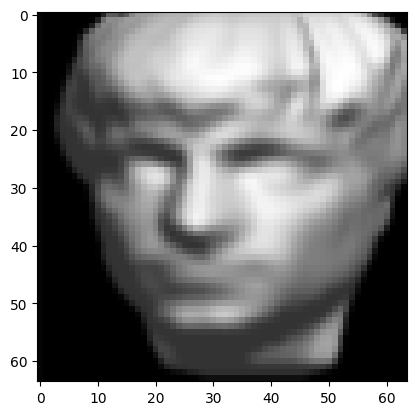

In [37]:
# Image properties:
Pict_H = 64 # Height
Pict_W = 64 # Width

# Show one image
img = image_matrix(data[:,600], Pict_H, Pict_W)
plt.imshow(img,cmap='gray') # Show image

#### *First Part:*  

We visualize the nearest neighbor graph and illustrate a few images corresponding to nodes at different parts of the graph.  

The first step of the algorithm is to create the adjacency matrix based on a given ϵ value. The value is changed to create non-inf values on the D matrix and at the same time obtain similar results to the ones observed in the paper. A value of ϵ=12 is found to generate similar results. 

We start by creating the graph:

In [38]:
# Create the weighted nearest neighbor graph
Epsilon = 12
A = Neigh_graph( data, Epsilon) 


Plotting the sparse adjacency matrix to visualize the non zero values connecting the different pictures we get the following: 

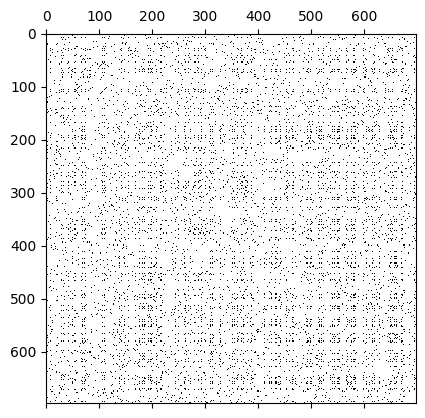

In [39]:
 # Visualize the sparse matrix A
plt.spy(A)
plt.savefig('AdjacencyMatrix_Part-b.png', dpi = 200)

Each point represents the connected elements between each of the 698 images under the defined ϵ value. Taking a closer look (zooming in) a section of the sparse matrix we can see the connecting dots between images:

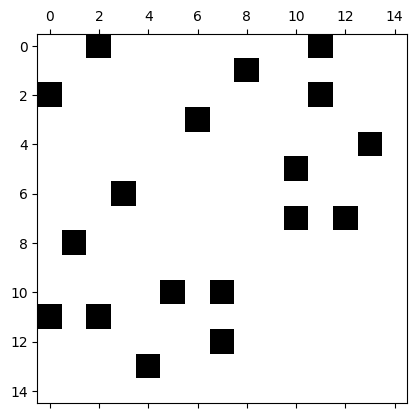

In [40]:
# Zoom in:
plt.spy(A[0:15,0:15])
plt.savefig('AdjacencyMatrix_Part-b_Zoom.png', dpi = 200)

This shows the connection between images 0 to 15. If we look in particular to the connections of images 0-2 and 1-8 (A[0,2] , A[1,8]) with eucledian distances:

In [44]:
# Looking a two particular image connectivity:
A[0,2] , A[1,8]

(np.float64(6.743239666821453), np.float64(11.889321318447799))

we see that the images compared are:

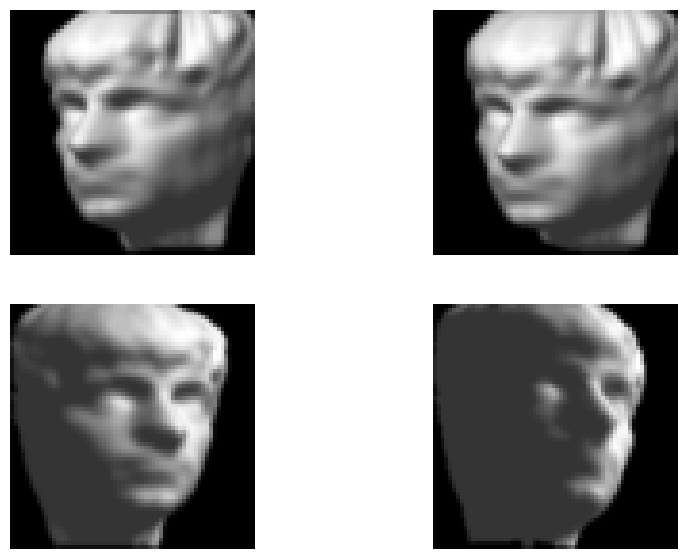

In [45]:
# Plot both figure connections
fig = plt.figure(figsize=(10, 7))

# setting values to rows and column variables
rows = 2
columns = 2
IM = [0,2,1,8]

# Adds a subplot at the 1st position
for i in range(len(IM)):
    fig.add_subplot(rows, columns, i+1)
    
    # showing image
    img = image_matrix(data[:,IM[i]], Pict_H, Pict_W)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

# Save to file
plt.savefig('AdjacencyMatrix_Part-b_Comparison.png')

it is clear they show a similar pose position

We can also visualize the connection using a network graph. We can use the NetworkX module:

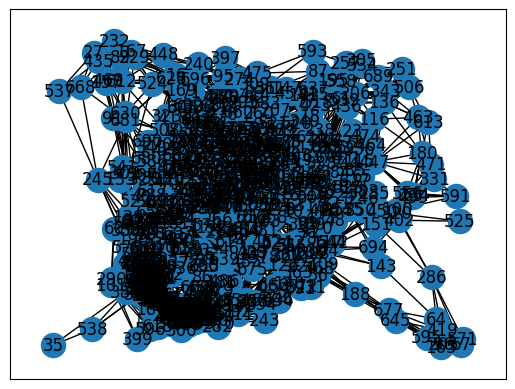

In [70]:
ggg = nx.from_numpy_array(A)
nx.draw_networkx(ggg)

Zooming in:

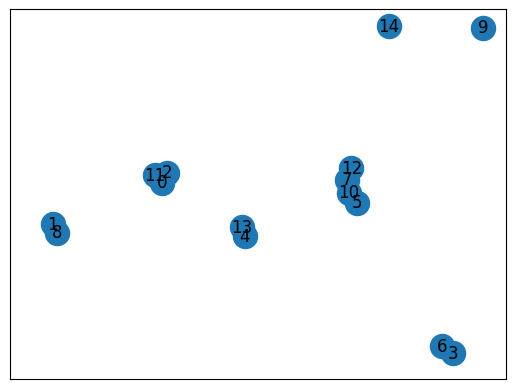

In [72]:
ggg = nx.from_numpy_array(A[0:15,0:15])
nx.draw_networkx(ggg)


#### *Second Part:*  

We now implement the ISOMAP algorithm to obtain a two-dimensional low-dimensional embedding. We will then plot the embeddings using a scatter plot and find a few images in the embedding space. Will then show what these images look like and specify the face locations on the scatter plot.

Implement ISOMAP algorithm:  
  
We start by creating the shortes distance matrix:

In [74]:
# Compute shortest distance matrix D
D = cs.shortest_path(A)

# Verify maximum value of D. (if inf values are shown then disconnected nodes are present). Find good epsilon without inf values, that does not necessarily means minimum epsilon without epsilon, since shortest distance may vary.
D.max()

np.float64(105.41919656369936)

In [75]:
# Now construct the centering matrix H
H = np.eye(n) - np.ones(n)/n

# And the G tilde matrix
Gtilde = -0.5 * np.matmul( H, D**2)
Gtilde = np.matmul( Gtilde, H)


# Eigendecomposition of Gtilde

K = 2  # number of principal values

S , U = ll.eigs(Gtilde,k = K)
S = S.real
U = U.real

We verify the eigendecomposition dimensions:

In [76]:
U.shape , S.shape

((698, 2), (2,))

In [77]:
# Calculate Z tilde 
# Each row corresponds to one eigen value 
ZtildeT = ( np.matmul( U, np.eye(K)*S**0.5 ) )

Now we plot the ISOMAP principal directions:

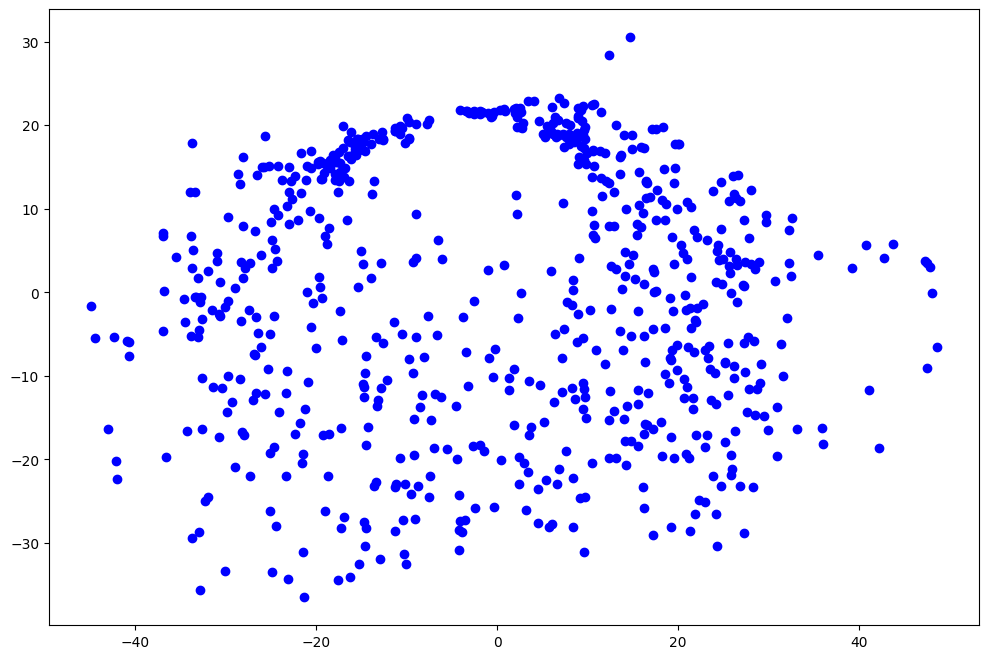

In [82]:
# Plot ISOMAP Principal Directions
face_fig = plt.figure( figsize=(12,8))

face_fig.gca().scatter(ZtildeT[:,0], ZtildeT[:,1], c = 'b', marker = 'o' )
face_fig.savefig('ISOMAP_Part-b.png')
    

what is a very close representation of the results obtained in the paper.  
We now repeat the plotting and include a few of the images and the position in the scatter plot:

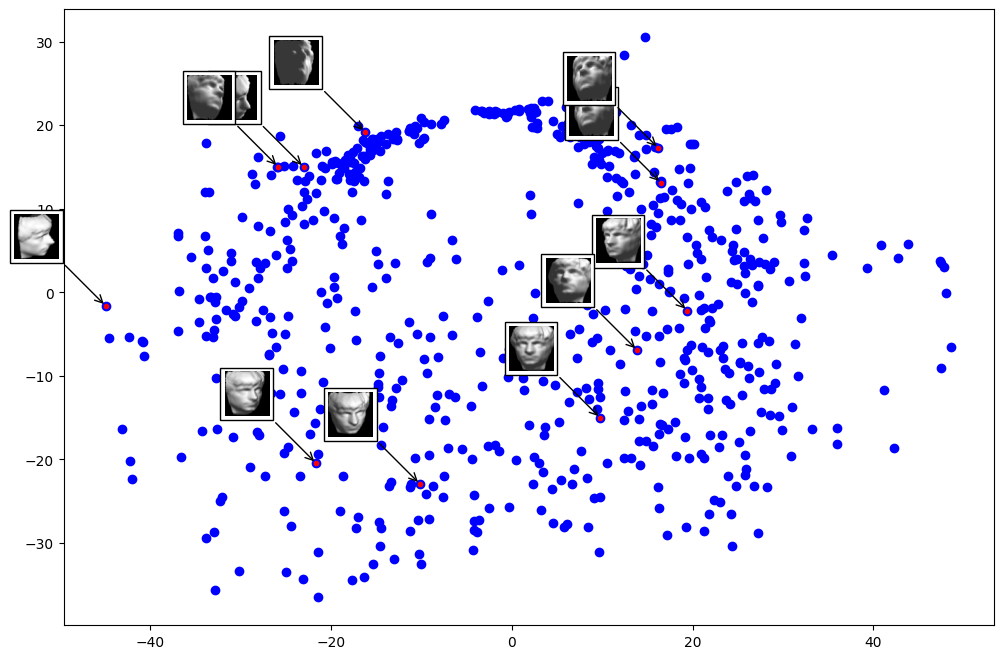

In [79]:
# Plot ISOMAP Principal Directions
face_fig, ax = plt.subplots( figsize=(12,8))

face_fig.gca().scatter(ZtildeT[:,0], ZtildeT[:,1], c = 'b', marker = 'o' )

# Annotate images on selected points
data_point = [0,25,50,75,100,125,150,175,200,225,300 ]
data_point_x = ZtildeT[data_point,0]
data_point_y = ZtildeT[data_point,1]

for point in range(len(data_point)):
    img = image_matrix(data[:, data_point[point] ], Pict_H, Pict_W)
    im = OffsetImage(img, cmap=plt.cm.gray, zoom=0.5)

    # Define position to annotate (display it with a marker)
    xy = (data_point_x[point], data_point_y[point])
    ax.plot(xy[0], xy[1], ".r")
    im.image.axes = ax

    ab = AnnotationBbox(im, xy,
        xybox=(-50., 50.),
        xycoords='data',
        boxcoords="offset points",
        pad=0.3,
        arrowprops=dict(arrowstyle="->"))

    ax.add_artist(ab)

face_fig.savefig('ISOMAP_Part-b_images.png')

We increase the number of images in an homogeneous way:

In [80]:
#### Divide in quadrants for an even image recognition
# Axis splits
nx = 8
ny = 8

DeltaX = ( max( ZtildeT[:,0] ) - min( ZtildeT[:,0] ) ) / nx
DeltaY = ( max( ZtildeT[:,1] ) - min( ZtildeT[:,1] ) ) / ny

Qij = []
for i in range(nx):
    Xmin = min( ZtildeT[:,0] )  + DeltaX * i
    Xmax = Xmin + DeltaX
    
    # filter in X quadrant range
    ValuesX = ZtildeT[ ZtildeT[:,0] >= Xmin ] 
    ValuesX = ValuesX[ ValuesX[:,0] < Xmax ]

    for j in range(ny):
        Ymin =  min( ZtildeT[:,1] ) + DeltaY * j
        Ymax = Ymin + DeltaY
        
        # filter in Y quadrant range
        ValuesY = ValuesX[ ValuesX[:,1] >= Ymin]
        ValuesY = ValuesY[ ValuesY[:,1] < Ymax]

        # Get a randow element from the quadrant, if a value exists
        if ValuesY.any() != False:
            a = random.choice( list( ValuesY ) )
        
            # Get index value
            index = np.where( ZtildeT == a )[0][0] 

            # Populate list
            Qij.append(index)

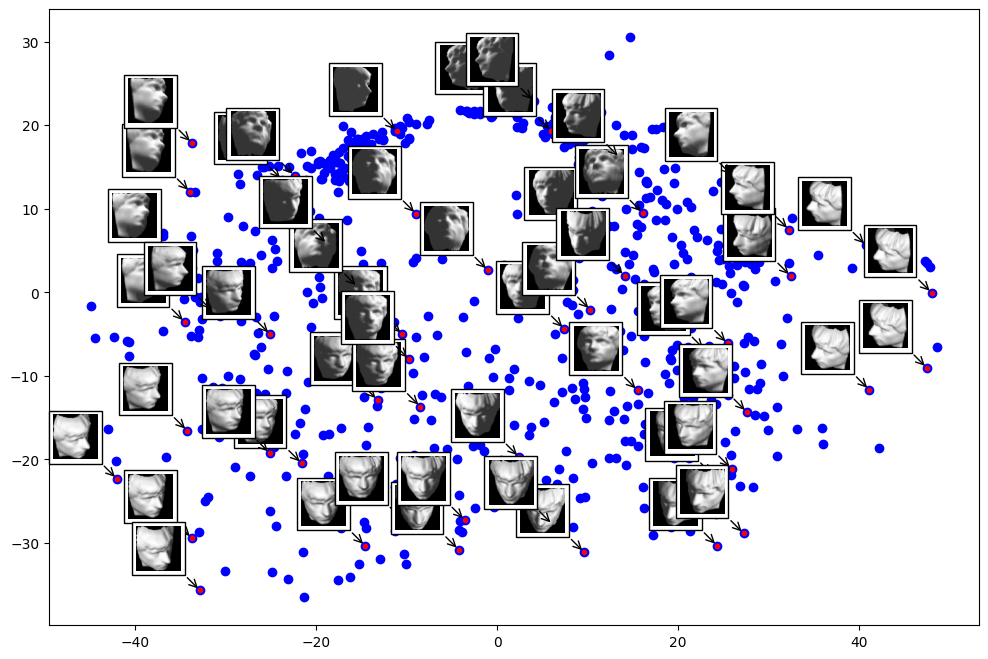

In [81]:
# Plot ISOMAP Principal Directions 
# Aggregate pictures selected in given quadrants
face_fig, ax = plt.subplots( figsize=(12,8))

face_fig.gca().scatter(ZtildeT[:,0], ZtildeT[:,1], c = 'b', marker = 'o' )

# Annotate images on selected points
data_point = Qij
data_point_x = ZtildeT[data_point,0]
data_point_y = ZtildeT[data_point,1]

for point in range(len(data_point)):
    img = image_matrix(data[:, data_point[point] ], Pict_H, Pict_W)
    im = OffsetImage(img, cmap=plt.cm.gray, zoom=0.5)

    # Define position to annotate (display it with a marker)
    xy = (data_point_x[point], data_point_y[point])
    ax.plot(xy[0], xy[1], ".r")
    im.image.axes = ax

    ab = AnnotationBbox(im, xy,
        xybox=(-30., 30.),
        xycoords='data',
        boxcoords="offset points",
        pad=0.3,
        arrowprops=dict(arrowstyle="->"))

    ax.add_artist(ab)

face_fig.savefig('ISOMAP_Part-b_images.png')

Plotting the pictures in the same scatter plot, we can get a better idea of the results of the ϵ−ISOMAP. The images represented in the embedding follow a distinctive face direction depending on the quadrant position in the scatter plot. The faces at the left looking right (in the plot) change towards left looking while transitioning to the right side of the plot. In the same way, bottom to top looking images transition from bottom points to top points of the plot. There is a clear correlation between position and face pointing direction.


#### *Third Part:*  

We now perform a simple principal component analysis (PCA) on the data (images) and project them into the top 2 principal components. We want to compare with the previous results by showing them again on a scatter plot.

In [85]:
# Perform PCA
mu = np.mean(data,axis = 1)
xc = data - mu[:,None]

C = np.dot(xc,xc.T)/m

K = 2
S,W = ll.eigs(C,k = K)
S = S.real
W = W.real

dim = np.dot(W[:,:].T,xc)  # extract eigenvalues ()

dim = dim.T # Transpose to use same format as in previous part

Now we plot the two principal components in a scatter plot:

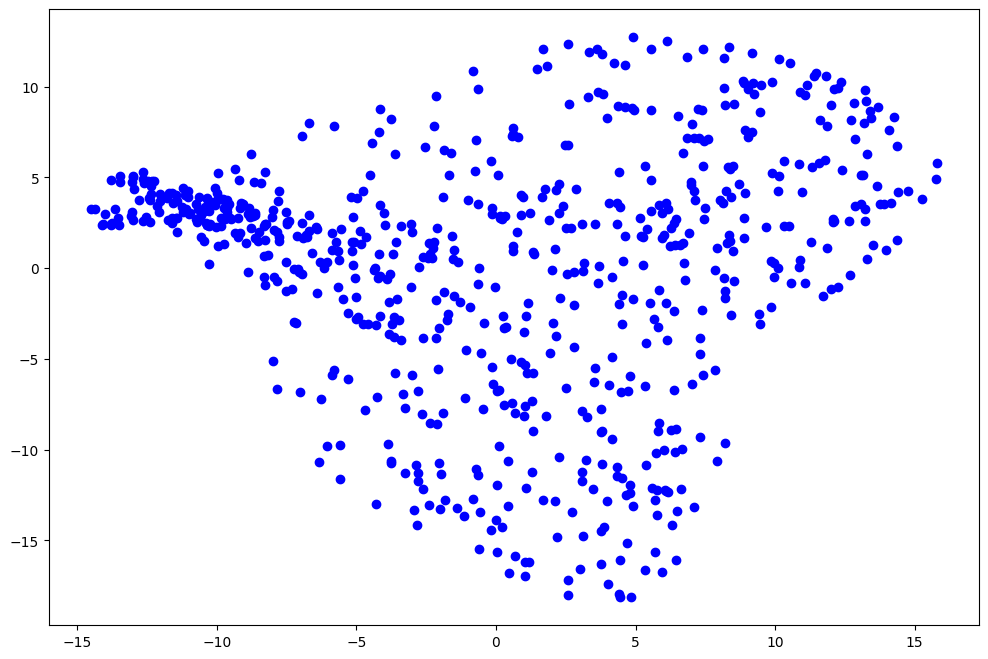

In [86]:
# Plot PCA Principal Directions
face_fig = plt.figure( figsize=(12,8))

face_fig.gca().scatter(dim[:,0], dim[:,1], c = 'b', marker = 'o' )
face_fig.savefig('PCA_Part-c.png')

The results are more evident by superimposing the corresponding images of some of the points in the scatter plot, as done in the previous ISOMAP case.

In [87]:
#### Divide in cuadrants for an even image recognition
# Axis splits
nx = 8
ny = 8

DeltaX = ( max( dim[:,0] ) - min( dim[:,0] ) ) / nx
DeltaY = ( max( dim[:,1] ) - min( dim[:,1] ) ) / ny

Qij = []
for i in range(nx):
    Xmin = min( dim[:,0] )  + DeltaX * i
    Xmax = Xmin + DeltaX
    
    # filter in X quadrant range
    ValuesX = dim[ dim[:,0] >= Xmin ] 
    ValuesX = ValuesX[ ValuesX[:,0] < Xmax ]

    for j in range(ny):
        Ymin =  min( dim[:,1] ) + DeltaY * j
        Ymax = Ymin + DeltaY
        
        # filter in Y quadrant range
        ValuesY = ValuesX[ ValuesX[:,1] >= Ymin]
        ValuesY = ValuesY[ ValuesY[:,1] < Ymax]

        # Get a randow element from the quadrant, if a value exists
        if ValuesY.any() != False:
            a = random.choice( list( ValuesY ) )
        
            # Get index value
            index = np.where( dim == a )[0][0] 

            # Populate list
            Qij.append(index)

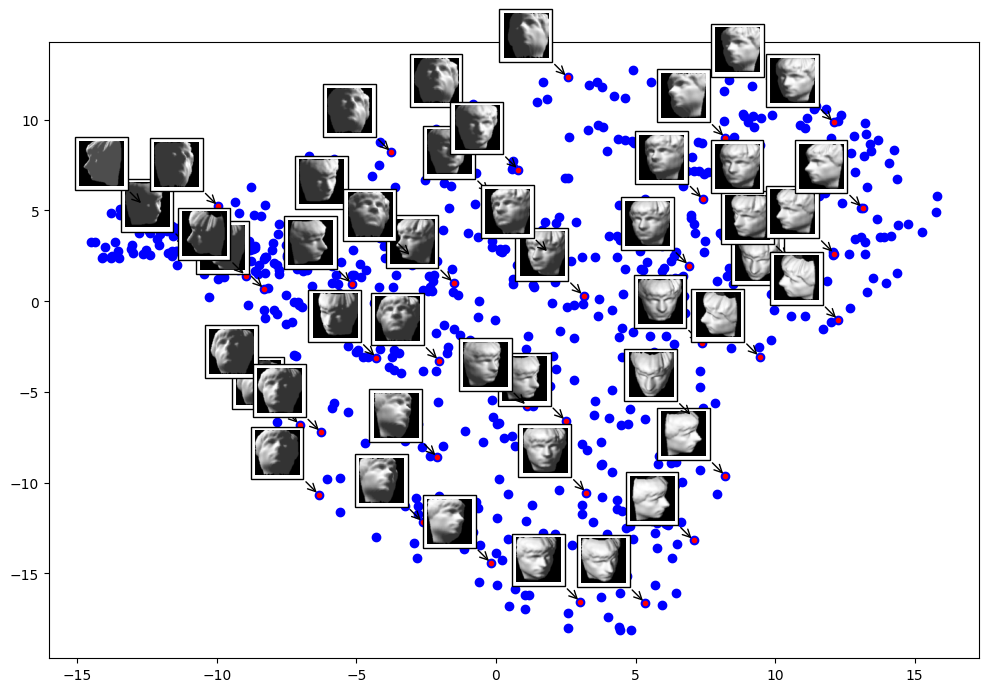

In [88]:
# Plot PCA Principal Directions 
# Aggregate pictures selected in given quadrants
face_fig, ax = plt.subplots( figsize=(12,8))

face_fig.gca().scatter(dim[:,0], dim[:,1], c = 'b', marker = 'o' )

# Annotate images on selected points
data_point = Qij
data_point_x = dim[data_point,0]
data_point_y = dim[data_point,1]

for point in range(len(data_point)):
    img = image_matrix(data[:, data_point[point] ], Pict_H, Pict_W)
    im = OffsetImage(img, cmap=plt.cm.gray, zoom=0.5)

    # Define position to annotate (display it with a marker)
    xy = (data_point_x[point], data_point_y[point])
    ax.plot(xy[0], xy[1], ".r")
    im.image.axes = ax

    ab = AnnotationBbox(im, xy,
        xybox=(-30., 30.),
        xycoords='data',
        boxcoords="offset points",
        pad=0.3,
        arrowprops=dict(arrowstyle="->"))

    ax.add_artist(ab)

face_fig.savefig('PCA_Part-c_images.png')

Is now evident that the faces do not follow a pattern depending on the plot position as seen for ISOMAP. In some areas (for example -5,5 ) faces pointing in different directions are place close to one another. Indeed ISOMAP creates a more meaningful result.